[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/KitchinHUB/si-dynamic-catalysis-1/blob/master/Others/16-Sensitivity_analysis_amplitude_offset.ipynb)

# Notebook #16: Sensitivity analysis on amplitude and offset

This notebook is part of the Supporting Information for the paper *Cyclic steady state simulation and waveform design for Dynamic/Programmable Catalysis*, by C. C. Tedesco, J. R. Kitchin, and C. D. Laird.

This notebook contains code used to obtain **Figure S4**, to analyze the effects of using different combinations of amplitude and offset parameters in the time-average turnover frequency (avTOF) and optimal duty cycle, when using a square waveform as a forcing signal for dynamic catalysis systems. 

## Install Pyomo and IPOPT on Google Colab

In [ ]:
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin 
    os.environ['PATH'] += ':bin'

!pip install munch 

In [1]:
from munch import Munch
import numpy as np
from pyomo.environ import (ConcreteModel, Constraint, Objective, Var, Param,
                           SolverFactory, value, sin, cos, Set,
                           TransformationFactory, assert_optimal_termination, RangeSet)
from pyomo.dae import ContinuousSet, DerivativeVar
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sys
import pandas as pd
from scipy import signal
from tqdm import tqdm 
from itertools import combinations
import idaes
from scipy.optimize import minimize
import time
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

## Declaring parameter values

In [3]:
class Params:
    """
    Declares reactive system, catalyst and CSTR model parameters
    """
    
    def __init__(self,  T = 423.15, # K
                        q = 0.0008333, # L/s
                        Po = 1.01325, # bar
                        Rg_constants = 0.0083144626, # kJ/K-gmol
                        Rg_Caf = 0.083144626, # bar-L/K-gmol
                        Rg_ODEs = 0.083144626, # bar-L/K-gmol
                        kB = 1.380649e-23, # J/K
                        hp = 6.62607015e-34, # J-s
                        F = 96.485, # mC/gmol
                        alpha = 0.6, 
                        beta = 100,
                        gamma = 2, 
                        delta = 1.4, # eV
                        H1 = 0, # kJ/mol
                        H2 = 0, # kJ/mol
                        N = 2.76e-6, # gmol sites
                        V = 2.60e-4, # L
                        Caf = 2.8423101747069843, # mol/L
                        Cbf = 0, # mol/L
                        delS1 = -135, # J/mol-K
                        delS2 = 0, # J/mol-K
                        delS3 = 135, # J/mol-K
                        number_periods = 1,
                        nfe = 900
                        ):
        
        
        self.T = T # Temperature on the simulated CSTR
        self.Po = Po # Standard pressure
        self.Caf = Caf # Initial concentration of A
        self.Cbf = Cbf # Initial concentration of B
        self.Rg_constants  = Rg_constants # Gas constant used in rate constants calculation
        self.Rg_Caf = Rg_Caf # Gas constant used to calculate Caf
        self.Rg_ODEs = Rg_ODEs # Gas constant used in the ODEs
        self.kB = kB # Boltzmann constant
        self.hp = hp # Plank constant
        self.F = F  # Faraday constant, for unit conversion
        self.alpha = alpha # Parameter for the BEP linear scaling relashionship
        self.beta = beta # Parameter for the BEP linear scaling relashionship
        self.gamma = gamma # Parameter for the binding energies linear scaling relashionship
        self.delta = delta # Parameter for the binding energies linear scaling relashionship
        self.H1 = H1 # Enthalpy of A
        self.H2 = H2 # Enthalpy of B
        self.V = V # Volume of the CSTR
        self.delS1 = delS1 # Entropy of A
        self.delS2 = delS2 # Entropy of reaction
        self.delS3 = delS3 # Entropy of B
        self.q = q # Volumetric rate of the reactor
        self.N = N # Number of active sites on the surface
        self.number_periods = number_periods # Number of periods to be simulated 
        self.nfe = nfe # Number of discretization points

## Calculate the periodic rate constants from the forcing signal for binding energy

In [4]:
def time_dependent_params(params, t):
    """
    Calculates rate constants from the periodic binding energy of A
    
    Args:
        params: From where to take the parameter values. For now we only have one option, the class "Params"

    Returns:
        Munch callables for the rate constants
    """
    
    # Parameters as given in the Params class
    T = params.T
    Rg_constants = params.Rg_constants
    kB = params.kB
    hp = params.hp
    F = params.F
    alpha = params.alpha
    beta = params.beta
    gamma = params.gamma
    delta = params.delta
    H1 = params.H1
    H2 = params.H2
    delS1 = params.delS1
    delS2 = params.delS2
    delS3 = params.delS3
    amplitude = params.amplitude # Amplitude of the wave (decision variable)
    offset = params.offset # Offset of the wave: determines the values of binding energy of A (decision variable)
    freq_osci = params.freq_osci # Frequency of the wave (decision variable)
    duty_cycle = params.duty_cycle # Duty cycle of the square wave (decision variable)
    
    # Binding energy calculation (eV)
    # Oscillation in square waveform
    # The frequency term is given as 1 because the time span is scaled
    BEa = amplitude * signal.square(2 * np.pi * 1 * t, duty = duty_cycle) + offset
        
    # Binding energy values for B, from the linear relationship with Bea   
    BEb = gamma * BEa + H2 / F - gamma * H1 / F + (1 - gamma) * delta

    # Heat of reaction (kJ/mol)
    delH1 = -BEa * F # For the adsorption step
    delH2 = (H2 - BEb * F) - (H1 - BEa * F) # For the surface reaction step
    delH3 = BEb * F # For the desorption step

    # Activation energy from BEP relationship (kJ/mol)
    Ea = alpha * delH2 + beta

    # Gibbs free energy  
    delG1 = delH1 - T * delS1 * 0.001 # For the adsorption step
    delG2 = delH2 - T * delS2 * 0.001 # For the surface reaction step
    delG3 = delH3 - T * delS3 * 0.001 # For the desorption step

    # Equilibrium constants (unitless)
    K1 = np.exp(-delG1 / Rg_constants / T) # For the adsorption step
    K2 = np.exp(-delG2 / Rg_constants / T) # For the surface reaction step 
    K3 = np.exp(-delG3 / Rg_constants / T) # For the desorption step

    # Rate constants (1/s)
    kf1 = ((kB * T) / hp) * np.exp(delS1 * 0.001 / Rg_constants) # For the adsorption of A
    kf2 = ((kB * T) / hp) * np.exp(-Ea / Rg_constants / T) # For the forward surface reaction
    kr3 = ((kB * T) / hp)*np.exp(-delS3 * 0.001 / Rg_constants) # For the adsorption of B
    kr1 = kf1 / K1 # For the desorption of A
    kr2 = kf2 / K2 # For the reverse surface reaction
    kf3 = kr3 * K3 # For the desorption of B
    
    return Munch(kf1 = kf1, kf2 = kf2, kf3 = kf3, kr1 = kr1, kr2 = kr2, kr3 = kr3, BEa = BEa)

## Create the Pyomo model

In [5]:
def create_pyomo_model(params):
    """
    Creates the pyomo model for the CSTR. Uses Backwards Finite Difference method to discretize the time span and 
    a system of equations from the ODE system modelled here. 
    
    Args:
        params: From where to take the parameter values. For now we only have one option, the class "Params"

    Returns:
        Discretized Pyomo model
    """

    # Parameters as given in the class
    T = params.T
    q = params.q
    Po = params.Po
    Caf = params.Caf
    Cbf = params.Cbf
    Rg_constants = params.Rg_constants
    Rg_Caf = params.Rg_Caf
    Rg_ODEs = params.Rg_ODEs
    kB = params.kB
    hp = params.hp
    F = params.F
    alpha = params.alpha
    beta = params.beta
    gamma = params.gamma
    delta = params.delta
    H1 = params.H1
    H2 = params.H2
    amplitude = params.amplitude
    N = params.N
    V = params.V
    offset = params.offset
    delS1 = params.delS1
    delS2 = params.delS2
    delS3 = params.delS3
    freq_osci = params.freq_osci
    duty_cycle = params.duty_cycle
    number_periods = params.number_periods
    nfe = params.nfe
    
    # Create Pyomo model and parameters
    m = ConcreteModel()
    m.params = params
    
    # Create time span
    # Scaling time to be between 0 and 1 
    m.tau = ContinuousSet(bounds=(0, 1)) 
    # True time span, dependent of tau
    m.times = Var(m.tau) 
    
    # Parameter fir the final time to be equal the number of periods times the wave period 
    m.tf = Param(initialize = params.number_periods*1/params.freq_osci)
    
    # Define variables- concentrations varying with time, 
    # initialized in values that would make sense to be the solution
    m.Ca = Var(m.tau, initialize = 2.84)
    m.Cb = Var(m.tau, initialize = 0.1)
    m.thetaA = Var(m.tau, initialize = 0.5)
    m.thetaB = Var(m.tau, initialize = 0.5)

    # Declare derivative variables
    m.dtimedtau = DerivativeVar(m.times) # For time scaling
    m.dCadt = DerivativeVar(m.Ca)
    m.dCbdt = DerivativeVar(m.Cb)
    m.dthetaAdt = DerivativeVar(m.thetaA)
    m.dthetaBdt = DerivativeVar(m.thetaB)

    # Constraint that says dtime/dtau = final time, since time = tau * final time
    @m.Constraint(m.tau)
    def _ode3(m,t):
        if t == 0:
            return Constraint.Skip
        return m.dtimedtau[t] == m.tf
    
    # Declare ODEs as contraints

    @m.Constraint(m.tau)
    # Define equation that is a function of the model and t
    def dCadt_eq(m,t):
        # pt gets the result of the function 
        pt = time_dependent_params(m.params, t)
        # Declare theta_star since it varies with thetaA and B and therefore, with time
        theta_star = 1 - m.thetaA[t] - m.thetaB[t]
        # ODE, being that `munch` format was used to get the k's from the function
        # Multiply the final time for time scaling
        return m.dCadt[t] == m.tf * ((q / V) * (Caf - m.Ca[t]) \
            - pt.kf1 * m.Ca[t] * Rg_ODEs * T * (theta_star) / Po * (N / V) + pt.kr1 * m.thetaA[t] * (N / V))

    @m.Constraint(m.tau)
    def dCbdt_eq(m,t):
        pt = time_dependent_params(m.params, t)
        theta_star = 1 - m.thetaA[t] - m.thetaB[t]
        return m.dCbdt[t] == m.tf * ((q / V) * (Cbf - m.Cb[t]) \
            + (pt.kf3 * m.thetaB[t] - pt.kr3 * m.Cb[t] * Rg_ODEs * T * (theta_star) / Po) * (N / V))

    @m.Constraint(m.tau)
    def dthetaAdt_eq(m,t):
        pt = time_dependent_params(m.params, t)
        theta_star = 1 - m.thetaA[t] - m.thetaB[t]
        return  m.dthetaAdt[t] == m.tf * (pt.kf1 * m.Ca[t] * Rg_ODEs * T * (theta_star) / Po \
            - pt.kr1 * m.thetaA[t] - pt.kf2 * m.thetaA[t] + pt.kr2 * m.thetaB[t])
    
    @m.Constraint(m.tau)
    def dthetaBdt_eq(m,t):
        pt = time_dependent_params(m.params, t)
        theta_star = 1 - m.thetaA[t] - m.thetaB[t]
        return m.dthetaBdt[t] == m.tf * ((pt.kf2 * m.thetaA[t] - pt.kr2 * m.thetaB[t]) \
            - (pt.kf3 * m.thetaB[t] - pt.kr3 * m.Cb[t] * Rg_ODEs * T * (theta_star) / Po))

    # Declare discretization method and parameters 
    discretizer = TransformationFactory('dae.finite_difference')
    discretizer.apply_to(m, nfe = nfe, scheme='BACKWARD')
    
    # Return the model
    return m

## Solving the model and calculating avTOF from the results

In [6]:
def tof_from_decision_vars(params, tee=True):
    """
    Solves the Pyomo model and calculates avTOF from results of solving the BVP
    
    Args:
        params: From where to take the parameter values. For now we only have one option, the class "Params"
        tee = True: Returns the ipopt log, which is advised. Use Tee = False in case you do not want to see the log.

    Returns:
        Value of the time-averaged turnover frequency
    """
        
    # Get the Pyomo model with final time as the number of periods times the period of the forcing wave
    m = create_pyomo_model(params)

    
    # Key part of the approach!
    # Equality constraints for initial and final points - to guarantee periodicity 
    # and simulation of full cycles
    m.CaCSS = Constraint(expr= m.Ca[m.tau.first()] == m.Ca[m.tau.last()])
    m.CbCSS = Constraint(expr= m.Cb[m.tau.first()] == m.Cb[m.tau.last()])
    m.thetaACSS = Constraint(expr= m.thetaA[m.tau.first()] == m.thetaA[m.tau.last()])
    m.thetaBCSS = Constraint(expr= m.thetaB[m.tau.first()] == m.thetaB[m.tau.last()])

    # Call ipopt as solver on the square problem/ simulation
    solver = SolverFactory('ipopt')
    # If solving in a loop, terminate runs when unable to solve
    status = solver.solve(m, tee=tee)
    assert_optimal_termination(status)


    # Attributing arrays for calculating plotting
    Ca = [value(m.Ca[t]) for t in m.tau]
    Cb = np.asarray([value(m.Cb[t]) for t in m.tau])
    thetaA = [value(m.thetaA[t]) for t in m.tau]
    thetaB = [value(m.thetaB[t]) for t in m.tau]
    theta_star = [value(1 - m.thetaA[t] - m.thetaB[t]) for t in m.tau]

    # Calculating TOF from the concentration of product desorbed
    TOF = Cb*params.q/params.N
    
    # Calculating the time-average by integration with the trapezoid method
    avTOF = np.trapz(TOF/(1), m.tau) 
    return [TOF, avTOF]

## Getting the optimal duty cycle for each parameter set

In [7]:
params = Params()

# Define the objective function, which will receive the decision variables and parameters
def obj(duty, params):
    params.duty_cycle = duty
    
    TOF, avTOF = tof_from_decision_vars(params, tee=False)
    # The minus signal for the response will make the result to be for maximization, and not minimization
    return - avTOF
# A lambda function is used to create a function that takes the decision variables and gives avTOF
fun = lambda duty: obj(duty, params)

# The initial guess is given. Several values were tested and they lead to similar optimal results
# The order is duty cycle, frequency, amplitude, offset
initial_guess = 0.7

# Bounds are given for the search space
# The order once again is duty cycle, frequency, amplitude, offset
bnds=[(0.05, 0.95)]

# The callback function allows for printing the results in each iteration of the method
def callback(values):
    avTOF_value = obj(values, params)
    print(f'Duty = {values[0]}, avTOF = {-avTOF_value:1.2f}  Hz') 

In [8]:
def for_simulation(amplitude, offset):

    params = Params()
    
    params.amplitude = amplitude

    params.offset = offset

    avTOFss = []
    
    result_powell = minimize(fun, x0 = initial_guess, bounds = bnds, method ='Powell', tol = 1e-8, options = {'disp': True}, callback = callback)

    optimal_duty = result_powell.x[0]
    maximum_avTOF = result_powell.fun

    return optimal_duty, maximum_avTOF

## Simulating the sets for plotting

In [9]:
params = Params()

opt_duties = []
max_avTOFs = []

amplitudes = np.linspace(0.2, 0.4, 20)
offsets = np.linspace(1.2, 1.5, 20)

# Fixed amplitude 
params.freq_osci = 1500


for params.amplitude in amplitudes:
    
    for params.offset in offsets:
        

        optimal_duty, maximum_avTOF = for_simulation(params.amplitude, params.offset)
        opt_duties.append(optimal_duty)
        max_avTOFs.append(-maximum_avTOF)

        print(f' amplitude = {params.amplitude}, offset = {params.offset}, opt_duty = {optimal_duty}, max_avTOF = {-maximum_avTOF}')

Duty = 0.9489323963183154, avTOF = 3.78  Hz
Duty = 0.9493401762978463, avTOF = 3.78  Hz
Optimization terminated successfully.
         Current function value: -3.782325
         Iterations: 2
         Function evaluations: 130
 amplitude = 0.2, offset = 1.2, opt_duty = [0.94934018], max_avTOF = 3.782324734382283
Duty = 0.9489323963183154, avTOF = 4.90  Hz
Duty = 0.9493401762978463, avTOF = 4.90  Hz
Optimization terminated successfully.
         Current function value: -4.901084
         Iterations: 2
         Function evaluations: 130
 amplitude = 0.2, offset = 1.2157894736842105, opt_duty = [0.94934018], max_avTOF = 4.9010836505339395
Duty = 0.9489323963183154, avTOF = 6.35  Hz
Duty = 0.9493401762978463, avTOF = 6.35  Hz
Optimization terminated successfully.
         Current function value: -6.345475
         Iterations: 2
         Function evaluations: 130
 amplitude = 0.2, offset = 1.231578947368421, opt_duty = [0.94934018], max_avTOF = 6.345474837603906
Duty = 0.9489323963183154, a

In [21]:
opt_duties = np.array(opt_duties).reshape(20, 20) # Reshaping to be able to get the countour and 3D plots

In [20]:
max_avTOFs = np.array(max_avTOFs).reshape(20, 20)

## Maximum avTOF Contour plot

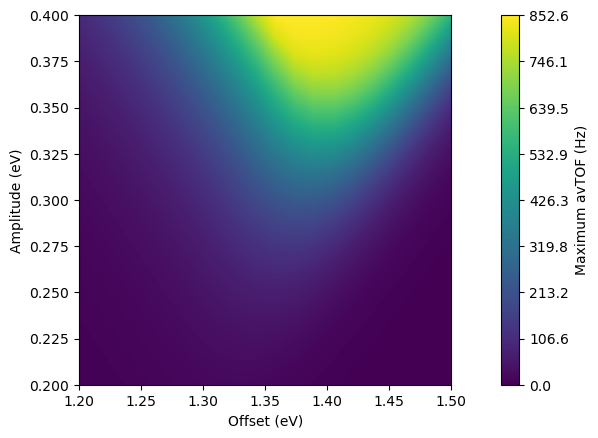

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111)

OFFSETS, AMPLITUDES = np.meshgrid(offsets, amplitudes)

contour = ax.contourf(OFFSETS, AMPLITUDES, max_avTOFs, cmap='viridis', levels=1000)

cbar = plt.colorbar(contour, label='Maximum avTOF (Hz)', ticks=np.linspace(np.min(max_avTOFs), np.max(max_avTOFs), 9), orientation='vertical', pad=0.1)

ax.set_xlabel('Offset (eV)')
ax.set_ylabel('Amplitude (eV)');

## Maximum avTOF 3D plot

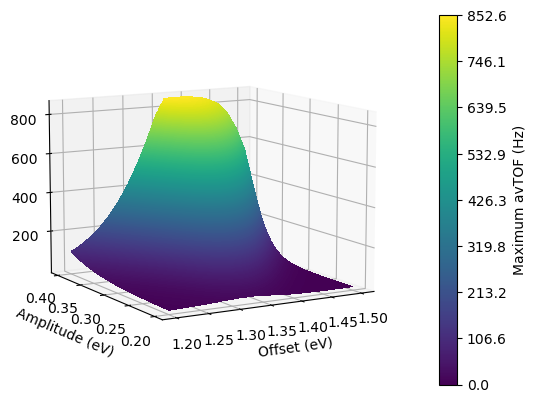

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

contour = ax.contourf(OFFSETS, AMPLITUDES, max_avTOFs, cmap='viridis', levels=1000)
cbar = plt.colorbar(contour, label='Maximum avTOF (Hz)', ticks=np.linspace(np.min(max_avTOFs), np.max(max_avTOFs), 9), orientation='vertical', pad=0.1)

ax.set_xlabel('Offset (eV)')
ax.set_ylabel('Amplitude (eV)')
ax.view_init(azim=240, elev=10);

## Optimal duty cycle Contour plot

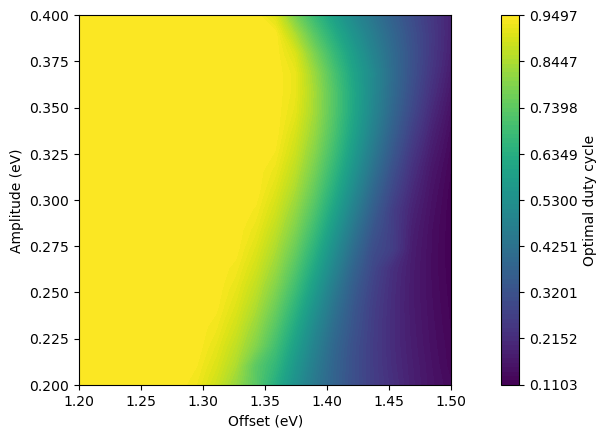

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)

contour = ax.contourf(OFFSETS, AMPLITUDES, opt_duties, cmap='viridis', levels=100)

cbar = plt.colorbar(contour, label='Optimal duty cycle', ticks=np.linspace(np.min(opt_duties), np.max(opt_duties), 9), orientation='vertical', pad=0.1)

ax.set_xlabel('Offset (eV)')
ax.set_ylabel('Amplitude (eV)');

## Optimal duty cycle 3D plot

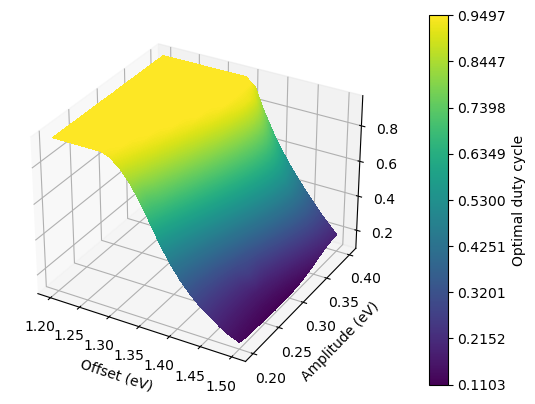

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

contour = ax.contourf(OFFSETS, AMPLITUDES, opt_duties, cmap='viridis', levels=1000)
cbar = plt.colorbar(contour, label='Optimal duty cycle', ticks=np.linspace(np.min(opt_duties), np.max(opt_duties), 9), orientation='vertical', pad=0.1)

ax.set_xlabel('Offset (eV)')
ax.set_ylabel('Amplitude (eV)');